In [3]:
import pandas as pd
from pathlib import Path
import os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# path assignments
root = 'Data/' # root direcotry 
data_filename = 'data_all.csv' # should be updated by the dataset name 
data_root = root + data_filename
# variable assignments

# ML variables
NORMALIZATION_TAG = False
train_split = 0.8

# trading sterategy variables
entry_threshold = 1.27
exit_threshold = 1.17
min_hold_time = 30
max_hold_time = 60


ModuleNotFoundError: No module named 'keras'

In [11]:
# read the data 
trade_df = pd.read_csv(data_root)
print('Data samples before processing: \n', trade_df.head(10))


# 1 - Pre-process data: cleaning/filling values
# As the data does not contain any additional features (X)
# and we only have the timestamps in minutes, 
# creating a meaningful model is a bit challenging, 
# so we need to add hypothetical features to the data as columns
# e.g., hour, day of the week, month, year, etc.

minute = 0
hour = 0 # 60
weekday = 0 # 60*24
month = 0 

trade_df['minute'] = 0
trade_df['hour'] = 0
trade_df['weekday'] = 0

for idx, row in trade_df.iterrows():
    if (idx+1)%60 == 0:
        minute = 0
        hour += 1
        if hour%24 == 0:
            hour = 0

    if (idx+1)%(60*24) == 0:
        weekday += 1
        if weekday%7 == 0:
            weekday = 0

    if (idx+1)%(60*24*30) == 0:
        month += 1
        if month%12 == 0:
            month = 0
    minute += 1
    trade_df['minute'].at[idx] = minute    
    trade_df['hour'].at[idx] = hour    
    trade_df['weekday'].at[idx] = weekday    

print('Data samples after processing: \n',trade_df.head(1440))



Data samples before processing: 
    Time   Price
0     0  1.2546
1     1  1.2567
2     2  1.2577
3     3  1.2579
4     4  1.2593
5     5  1.2668
6     6  1.2695
7     7  1.2689
8     8  1.2679
9     9  1.2679


NameError: name 'month' is not defined

In [88]:
# Pre-process data: get the X/Y set
X_set = trade_df[['minute','hour','weekday']]
Y_set = trade_df['Price']

print(X_set.head(70),Y_set.head(70))

    minute  hour  weekday
0        1     0        0
1        2     0        0
2        3     0        0
3        4     0        0
4        5     0        0
..     ...   ...      ...
65       7     1        0
66       8     1        0
67       9     1        0
68      10     1        0
69      11     1        0

[70 rows x 3 columns] 0     1.2546
1     1.2567
2     1.2577
3     1.2579
4     1.2593
       ...  
65    1.2674
66    1.2681
67    1.2678
68    1.2705
69    1.2714
Name: Price, Length: 70, dtype: float64


In [89]:

# Pre-process data: create train/test sets
X_set = trade_df[['minute','hour','weekday']]
Y_set = trade_df['Price']

print(X_set.head(100),Y_set.head(100))

X_train = X_set.iloc[:int(train_split*len(trade_df))].to_numpy()
Y_train = Y_set.iloc[:int(train_split*len(trade_df))].to_numpy()

X_test = X_set.iloc[int(train_split*len(trade_df)):].to_numpy()
Y_test = Y_set.iloc[int(train_split*len(trade_df)):].to_numpy()




    minute  hour  weekday
0        1     0        0
1        2     0        0
2        3     0        0
3        4     0        0
4        5     0        0
..     ...   ...      ...
95      37     1        0
96      38     1        0
97      39     1        0
98      40     1        0
99      41     1        0

[100 rows x 3 columns] 0     1.2546
1     1.2567
2     1.2577
3     1.2579
4     1.2593
       ...  
95    1.2826
96    1.2826
97    1.2829
98    1.2840
99    1.2833
Name: Price, Length: 100, dtype: float64


In [90]:
# Optional: Normalize the data
if NORMALIZATION_TAG:
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [91]:
# Reshape data for LSTM

time_window = 40  # Example time window size


def create_sequences_and_labels(data, labels, time_window):
    """
    Creates sequences of data and corresponding labels with a specific time window size.

    Parameters:
        data (numpy.ndarray): Input data with shape (n_samples, n_features).
        labels (numpy.ndarray): Target labels with shape (n_samples,).
        time_window (int): Size of the time window (number of time steps).

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Array of sequences with shape (n_samples - time_window + 1, time_window, n_features)
                                             and corresponding array of labels with shape (n_samples - time_window + 1,).
    """
    sequences = []
    target_labels = []
    n_samples = len(data)

    # Iterate through the data to create sequences and labels
    for i in range(n_samples - time_window + 1):
        sequence = data[i : i + time_window, :]
        label = labels[i + time_window - 1]  # Get the label for the last time step in the sequence
        sequences.append(sequence)
        target_labels.append(label)

    return np.array(sequences), np.array(target_labels)

# Create sequences of data with the specified time window size
X_train_reshaped, Y_train_reshaped = create_sequences_and_labels(X_train, Y_train, time_window)
X_test_reshaped, Y_test_reshaped = create_sequences_and_labels(X_test, Y_test, time_window)

print(X_train_reshaped.shape)


(51961, 40, 3)


In [92]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [93]:
# Train the model
model.fit(X_train_reshaped, Y_train_reshaped, epochs=2, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped))


Epoch 1/2
1624/1624 [==============================] - 27s 15ms/step - loss: 0.0161 - val_loss: 0.0135
Epoch 2/2
1624/1624 [==============================] - 25s 16ms/step - loss: 0.0144 - val_loss: 0.0109


In [94]:
# Evaluate the model
mse = model.evaluate(X_test_reshaped, Y_test_reshaped)

406/406 [==============================] - 2s 6ms/step - loss: 0.0109


In [95]:
# Make predictions
predictions = model.predict(X_test_reshaped)

406/406 [==============================] - 3s 6ms/step


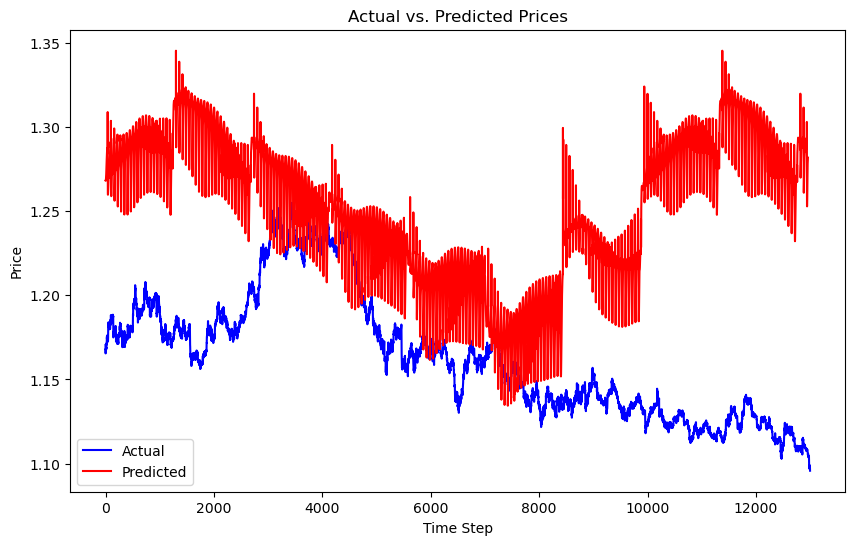

In [97]:
import matplotlib.pyplot as plt

# Assuming X_test_scaled and y_test are your scaled test data and labels

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [142]:
# Assuming X_Set and Y_Set are your input data and target labels
# Assuming X_Set has columns 'minute', 'hour', 'weekday' and Y_Set contains prices


HOLD_TAG = True
counter = 0
# Implement trading strategy
positions = []  # List to store trading positions (1 for buy, -1 for sell, 0 for hold)
entry_price = None
for i in range(len(predictions)):
    price = predictions[i][0]

    if entry_price is None:  # No position open
        if price > entry_threshold:
            positions.append(1)  # Buy
            entry_price = price
            counter += 1
        else:
            positions.append(0)  # Hold
    else:  # Position already open
        counter += 1
        if counter >= 30:
            if price < exit_threshold:
                positions.append(-1)  # Sell
                entry_price = None
                counter = 0
            elif counter == 60:
                positions.append(-1)  # Sell
                entry_price = None
                counter = 0                 
        else:
            positions.append(0)  # Hold
positions[-1] = -1
# Calculate profit based on trading positions
profit = 0
all_entered = [idx for idx, value in enumerate(positions) if value==1]
all_closed = [idx for idx, value in enumerate(positions) if value==-1]

pos_counter = 0
for i in range(1, len(positions)):
    if positions[i] == -1:  # Sell
        point_value = predictions[i] - predictions[i-1]
        profit +=  point_value # Profit from selling
        print('Opened at '+str(all_entered[pos_counter])+' ('+str(predictions[i][0])+'), close '+str(all_closed[pos_counter])+' ('+str(predictions[i][0])+') for profit ' + str(point_value[0]))
        pos_counter += 1
    elif positions[i] == 1:  # Buy
        profit -= predictions[i] - predictions[i-1]  # Loss from buying
print('Total Profit: '+str(profit[0]))

Opened at 11 (1.3087314), close 40 (1.3087314) for profit 0.024522781
Opened at 41 (1.2716366), close 70 (1.2716366) for profit 0.0005398989
Opened at 71 (1.3035359), close 100 (1.3035359) for profit 0.01576519
Opened at 101 (1.2735376), close 130 (1.2735376) for profit 0.00051796436
Opened at 131 (1.2990162), close 160 (1.2990162) for profit 0.008916855
Opened at 161 (1.2757273), close 190 (1.2757273) for profit 0.00046730042
Opened at 191 (1.2953514), close 220 (1.2953514) for profit 0.003874302
Opened at 221 (1.2783079), close 250 (1.2783079) for profit 0.00042366982
Opened at 251 (1.2926044), close 280 (1.2926044) for profit 0.00040626526
Opened at 281 (1.2812911), close 310 (1.2812911) for profit 0.00040733814
Opened at 311 (1.2907712), close 340 (1.2907712) for profit -0.0017834902
Opened at 341 (1.2845987), close 370 (1.2845987) for profit 0.00041902065
Opened at 371 (1.2898088), close 400 (1.2898088) for profit -0.0030111074
Opened at 401 (1.2880274), close 430 (1.2880274) for 